In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [2]:
% cd "/content/drive/My Drive/nnfl_project/"

/content/drive/My Drive/nnfl_project


# Imports


In [0]:
%tensorflow_version 1.x
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import fetch_20newsgroups
from keras.utils import to_categorical
import os
import glob
import numpy as np
import pickle
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

from keras.layers import *
from keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.regularizers import l1_l2
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import load_model
from keras import regularizers
from keras.utils.vis_utils import plot_model

from gensim.models import Word2Vec,KeyedVectors
from gensim.test.utils import datapath, get_tmpfile

PATH = '/content/drive/My Drive/nnfl_project/'
DATA_PATH = '/content/drive/My Drive/nnfl_project/data'
GLOVE_PATH = '/content/drive/My Drive/glove.840B.300d.txt'
# Change EMBED to 'glove' to use glove embeddings
EMBED = 'word2vec'

# Helper Functions

In [0]:
def evaluate(model,y_texts, y_labels, batch_size):

  loss, acc = model.evaluate(y_texts,y_labels,batch_size=batch_size,verbose=1)
  y_pred = model.predict(y_texts, batch_size=batch_size)

  y_pred_max_ind = np.argmax(y_pred,axis=1)
  y_true_max_ind = np.argmax(y_labels,axis=1)

  cf = (classification_report(y_true_max_ind,y_pred_max_ind))
  confusion_mat = confusion_matrix(y_true_max_ind, y_pred_max_ind)

  print("\n Model Accuracy : ",acc)
  print("\n Confusion Matrix: \n", confusion_mat)
  print("\nClassification Report\n ",cf)

def get_callbacks():

  chk_pth = ("{epoch:02d}_{val_categorical_accuracy:.2f}.h5")
  # early stopping
  earlyStop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, 
                            patience=2)
  checkpoint = ModelCheckpoint(chk_pth,monitor='val_categorical_accuracy', 
                               verbose=1, save_weights_only=True, 
                               save_best_only='True',mode = 'auto', period=2)
  cb = [checkpoint, earlyStop]
  return cb

def run_model(model, train_tokenized_seq, train_labels, epochs, batch_size, vsplit, init_epoch=0):

  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01),metrics=['categorical_accuracy'])

  # check if a saved_model exists
  # if(glob.glob('*.h5')):
  #   print("loading model")
  #   load_path = return_last_saved_model(glob.glob('*.h5'))
  #   # model = load_model(load_path)
  #   model.load_weights(load_path)
  #   init_epoch = get_epoch_frm_model_file(load_path)

  print("START TRAINING")

  start = time.time()
  history = model.fit(train_tokenized_seq,train_labels,epochs = init_epoch+epochs, batch_size=batch_size, validation_split=vsplit, callbacks=get_callbacks(), initial_epoch=init_epoch)
  end =  time.time()
  print("Training fininshed")
  # save_path = "{}_epochs-model.h5".format(init_epoch+epochs)
  # model.save(save_path)
  print("Average Time per epoch: ", (end-start)/len(history.history['loss']))
  return history

# plot model
def training_plots(history, model_name, model):  
  plt.plot(history.history["categorical_accuracy"])
  plt.plot(history.history["val_categorical_accuracy"])
  plt.title('model acc')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plt.plot(history.history["loss"])
  plt.plot(history.history["val_loss"])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epochs')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

  plot_model(model,to_file=model_name,show_shapes=True)

def tokenize_sequences(texts, sl, tokenizer):
  sequences = tokenizer.texts_to_sequences(texts)
  sequences = pad_sequences(sequences, maxlen=sl)

  return sequences

def get_data(data_path):
  newsgroups_data = fetch_20newsgroups(data_path, subset='all')
  labels = newsgroups_data.target
  texts = newsgroups_data.data

  from sklearn.model_selection import train_test_split

  train_texts, test_texts, train_labels, test_labels = train_test_split(texts, 
                                                                        labels, 
                                                                        test_size=0.1, 
                                                                        random_state=42)

  return train_texts, train_labels, test_texts, test_labels

def get_epoch_frm_model_file(save_path):
  return int(save_path[:save_path.index('_')])

def return_last_saved_model(paths):
  last_epoch_prev = -1
  ret_path = ""
  for path in paths:
    last_epoch = get_epoch_frm_model_file(path)
    if(last_epoch >= last_epoch_prev):
      last_epoch_prev = last_epoch
      ret_path = path
  return ret_path

def get_embedding_matrix(word2ix, glove_path, embedding_dim):
    """
    :param path: path to the glove embeddings file
    :param tokenizer: tokenizer fitted on the documents
    :param vocab_size: vocabulary size 
    :return: an embedding matrix: a nn.Embeddings
    """
    glove_vectors = {}
    glove_file = open(glove_path, 'r')
    for line in tqdm(glove_file):
        split_line = line.rstrip().split()
        word = split_line[0]
        if len(split_line) != (embedding_dim + 1) or word not in word2ix:
            continue
        assert (len(split_line) == embedding_dim + 1)
        vector = np.array([float(x) for x in split_line[1:]], dtype="float32")
        assert len(vector) == embedding_dim
        glove_vectors[word] = vector

    glove_file.close()

    print("Number of pre-trained word vectors loaded: ", len(glove_vectors))

    # Calculate mean and stdev of embeddings
    all_embeddings = np.array(list(glove_vectors.values()))
    embeddings_mean = float(np.mean(all_embeddings))
    embeddings_stdev = float(np.std(all_embeddings))

    vocab_size = len(word2ix)
    # Randomly initialize an embedding matrix of (vocab_size, embedding_dim) shape
    # with a similar distribution as the pretrained embeddings for words in vocab.
    embedding_matrix = np.random.normal(embeddings_mean, embeddings_stdev, (vocab_size, embedding_dim))

    for i, word in enumerate(word2ix):
        if word in glove_vectors:
            embedding_matrix[i] = glove_vectors[word]

    return embedding_matrix

# the following functions are for word2vec embeddings
def load_embedding(filename):
    # load embedding into memory, skip first line
    file = open(filename,'r')
    lines = file.readlines()[1:]
    file.close()
    # create a map of words to vectors
    embedding = dict()
    for line in lines:
        parts = line.split()
        # key is string word, value is numpy array for vector
        embedding[parts[0]] = np.asarray(parts[1:], dtype='float32')
    return embedding

def get_weight_matrix(embedding, vocab, embed_dim_w):
    vocab_size = len(vocab)
    weight_matrix = np.zeros((vocab_size, embed_dim_w))
    for word, i in vocab.items():
        if word in embedding:
            weight_matrix[i] = embedding.get(word)
    return weight_matrix

def get_w2v_matrix(vocab, embed_dim_w):
  raw_embedding = load_embedding('word2vec_200.txt')
  return (get_weight_matrix(raw_embedding, vocab, embed_dim_w))

def prepare_for_word_to_vec(texts):
  words_list = []
  for text in texts:
    tokens = word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    words_list.append(words)
  return words_list


# Configs

In [0]:
# in paper
vocab_size = 40439
embed_dim = 300 
embed_dim_w = 200
hidden_dim  = 128
batch_size  = 128
epochs = 50
init_epoch = 0
sl = 300
# TODO: add SL code
vsplit = 0.05

# Process Data

In [0]:
train_texts,train_labels, test_texts, test_labels = get_data(DATA_PATH)

# Should fit_to_texts complete or only train-  
# https://stackoverflow.com/questions/54891464/is-it-better-to-keras-fit-to-text-on-the-entire-x-data-or-just-the-train-data

tokenizer = Tokenizer(oov_token='<UNK>', num_words=vocab_size+1)
# fit only on train
tokenizer.fit_on_texts(train_texts)

# word2ix = truncated vocabulary or original vocabulary
word2ix = list(tokenizer.word_index.keys())[:vocab_size+1]
word2ix = {k:tokenizer.word_index[k] for k in word2ix}

train_tokenized_seq = tokenize_sequences(train_texts, sl, tokenizer)
test_tokenized_seq = tokenize_sequences(test_texts, sl, tokenizer)
# vocab_size = len(tokenizer.word_index)# +1 for OOV

train_labels = to_categorical(np.asarray(train_labels))
test_labels = to_categorical(np.asarray(test_labels))
output_dim = train_labels.shape[1]

# Load embeddings

In [63]:
# The following code is for training the word2vec algorithm on the dataset itself
path = get_tmpfile(PATH + 'word2vec_200.txt')
if(glob.glob('word2vec_200.txt')):
  print("Loading word2vec model ...")
  model_w = KeyedVectors.load_word2vec_format(path)
else:
  import nltk
  nltk.download('punkt')
  from nltk.tokenize import word_tokenize
  w_train = prepare_for_word_to_vec(train_texts)
  w_test = prepare_for_word_to_vec(test_texts)
  model_w = Word2Vec(w_train + w_test, size=embed_dim_w, sg=1, iter=15)

# Todo: save the vectors onto disk

if EMBED == 'word2vec':
  save_embedding_matrix_path = PATH + 'embedding_matrix_word2vec.pkl'

  if(glob.glob(save_embedding_matrix_path)):
    print('Word2vec Embedding matrix found. Loading ...')
    with open(save_embedding_matrix_path, 'rb') as f:
      embedding_matrix = pickle.load(f)

    print('Done.')

  else:
    embedding_matrix = get_w2v_matrix(word2ix, embed_dim_w)
    with open(save_embedding_matrix_path, 'wb+') as f:
      pickle.dump(embedding_matrix, f)

elif(EMBED == 'glove'):
  save_embedding_matrix_path = PATH + 'embedding_matrix_glove.pkl'

  if(glob.glob(save_embedding_matrix_path)):
    print('Glove Embedding matrix found. Loading ...')
    with open(save_embedding_matrix_path, 'rb') as f:
      embedding_matrix = pickle.load(f)

    print('Done.')

  else:
    embedding_matrix = get_embedding_matrix(word2ix, GLOVE_PATH, embed_dim)
    with open(save_embedding_matrix_path, 'wb+') as f:
      pickle.dump(embedding_matrix, f)

Loading word2vec model ...


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


Word2vec Embedding matrix found. Loading ...
Done.


In [64]:
print(train_tokenized_seq.shape)
print(train_labels.shape)

print(test_tokenized_seq.shape)
print(test_labels.shape)

print(embedding_matrix.shape)
print(vocab_size)

(16961, 300)
(16961, 20)
(1885, 300)
(1885, 20)
(40440, 200)
40439


# Models

In [0]:
import keras.backend as K

def repeat(x):
  return K.repeat_elements(x, rep=hidden_dim, axis=-1)

def sum_along_axis(x):
  return K.sum(x, axis=1)

def get_wrnn(rnn='gru'):
  inp = Input(shape=(sl,))
  embed = Embedding(input_dim=vocab_size+1, output_dim=embed_dim_w, 
                    weights=[embedding_matrix], input_length=sl,
                    trainable=True)(inp)
  if rnn == 'gru':
    lstm = GRU(hidden_dim, return_sequences=True, dropout=0.2)(embed)
  else:  
    lstm = LSTM(hidden_dim, return_sequences=True, recurrent_dropout=0.2, 
                dropout=0.2)(embed)
  wis = TimeDistributed(Dense(1, activation='sigmoid'))(lstm)
  wis = Lambda(repeat)(wis)
  wd = Multiply()([lstm, wis])
  wd = Lambda(sum_along_axis)(wd)
  d = Dense(hidden_dim, activation='relu', kernel_regularizer=regularizers.l2(0.01))(wd)
  d = Dropout(0.2)(d)
  out = Dense(output_dim, activation='softmax')(d)
  model_wrnn = Model(inputs = inp, outputs = out)
  print(model_wrnn.summary())
  return model_wrnn

def get_gru():
  model_gru = Sequential([Embedding(input_dim=vocab_size+1, output_dim=embed_dim, 
                                    weights=[embedding_matrix], input_length=sl, 
                                    trainable=True ), 
                        GRU(hidden_dim, dropout=0.2),
                        Dense(hidden_dim, activation='relu'),
                        Dense(output_dim, activation='softmax')])
  
  print(model_gru.summary())
  return model_gru

def get_bigru():
  model_BiGRU = Sequential([Embedding(input_dim=vocab_size+1, output_dim=embed_dim, 
                                      weights=[embedding_matrix], input_length=sl, 
                                      trainable=True ),
                        Bidirectional(GRU(hidden_dim, dropout=0.2)),
                        Dense(hidden_dim, activation='relu'),
                        Dense(output_dim, activation='softmax')])
  print(model_BiGRU.summary())
  return model_BiGRU

def perform_experiment(model):

  # training
  history = run_model(model, train_tokenized_seq, train_labels, epochs, 
                      batch_size, vsplit)
  training_plots(history, 'wrnn.png', model)

  # evaluation
  print("Evaluating...")
  evaluate(model, test_tokenized_seq, test_labels, batch_size)

## WRNN (with GRU unit)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_22 (InputLayer)           (None, 300)          0                                            
__________________________________________________________________________________________________
embedding_24 (Embedding)        (None, 300, 200)     8088000     input_22[0][0]                   
__________________________________________________________________________________________________
gru_5 (GRU)                     (None, 300, 128)     126336      embedding_24[0][0]               
__________________________________________________________________________________________________
time_distributed_6 (TimeDistrib (None, 300, 1)       129         gru_5[0][0]                      
___________________________________________________________________________________________

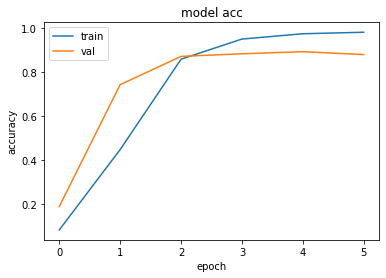

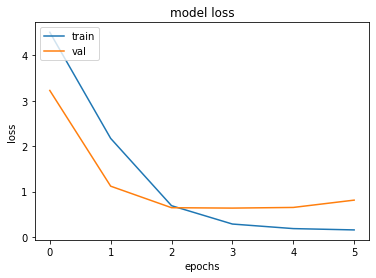

Evaluating...
1885/1885 [==============================] - 3s 2ms/step

 Model Accuracy :  0.8774535655975342

 Confusion Matrix: 
 [[67  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  2  3]
 [ 0 92  2  1  0  3  0  0  1  0  0  1  0  0  0  1  0  0  1  0]
 [ 1 12 90  6  1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0]
 [ 1  3  5 58  6  0  3  3  0  1  0  0  6  0  0  0  0  0  0  0]
 [ 0  1  2  1 97  0  0  1  0  0  0  0  2  0  0  0  0  0  0  0]
 [ 1  6  1  0  1 87  0  1  0  0  0  0  0  1  0  1  0  0  1  0]
 [ 1  3  1  5  2  0 72  6  4  0  2  1  1  0  0  0  0  0  0  0]
 [ 2  1  0  0  1  0  1 97  0  0  0  0  0  0  0  0  1  0  0  0]
 [ 0  0  0  0  1  1  0  2 79  0  0  0  0  0  0  0  2  0  0  1]
 [ 2  0  0  0  1  0  0  1  0 95  5  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0 94  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  2  0  0  0  0  0 96  0  0  0  1  2  0  3  0]
 [ 0  0  1  4  2  0  0  9  0  0  3  0 87  1  0  1  0  0  0  1]
 [ 0  1  0  0  0  0  0  1  1  0  0  0  1 90  1  0

In [58]:
model = get_wrnn()
perform_experiment(model)

## WRNN (with LSTM unit)

In [0]:
model = get_wrnn(rnn='lstm')
perform_experiment(model)

## Simple GRU

In [0]:
model = get_gru()
perform_experiment(model)

## BiGRU

In [0]:
model = get_bigru()
perform_experiment(model)

# Better models (not part of paper)

In [0]:
def get_new_model(rnn='gru'):
  inp = Input(shape=(sl,))
  embed = Embedding(input_dim=vocab_size+1, output_dim=embed_dim, 
                    weights=[embedding_matrix], input_length=sl, trainable=True)(inp)
  if rnn == 'gru':
    lstm = GRU(hidden_dim, return_sequences=True, dropout=0.2)(embed)
  else:
    lstm = LSTM(hidden_dim, return_sequences=True, recurrent_dropout=0.2, 
                dropout=0.2)(embed)
  conv1d = Conv1D(128, 1, activation='relu')(lstm)
  gp = GlobalMaxPooling1D()(conv1d)
  d = Dense(hidden_dim, activation='relu')(gp)
  d = Dropout(0.1)(d)
  out = Dense(output_dim, activation='softmax')(d)
  model = Model(inputs = inp, outputs = out)
  print(model.summary())
  return model

## GRU + Conv1d

In [0]:
model = get_new_model()
perform_experiment(model)

## LSTM + Conv1d

In [0]:
model = get_new_model(rnn='lstm')
perform_experiment(model)